# House Price Analytics

## 05 Data analysis for generating foresights

**Project:** Code Institute – Capstone Project

---
### **Objectives**
- Load the final house dataset
- Build a Machine Learning model to predict house prices with high accuracy

### **Inputs**
- `/data/models/house_price_model.pkl`

### **Outputs**
- Trained and finetuned Model to power a "Price Estimator" dashboard feature that gives Buyers and Sellers a realistic price range (Min, Average, Max).
        
### **Additional Comments**
Confirm the final_house_data.csv is exisit under outputs/datasets. Run this notebook top-down.

---

### Setup the file and Load the Dataset
Import nesessary libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Scikit-Learn
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Feature Engine
from feature_engine.selection import DropCorrelatedFeatures, SmartCorrelatedSelection
from feature_engine.encoding import OneHotEncoder

# Ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

Set the home directory. Need to change the working directory from its current folder to its parent folder. Access the current directory with os.getcwd()

In [3]:
PROJECT_DIR = os.path.join(os.getcwd()) # Define the project root directory
os.chdir(PROJECT_DIR) # Change the current working directory
# Uncomment the line below to verify the current working directory
# print("Working directory:", os.getcwd()) 

Load the data from the original data set reside within data directory under data/processed/ directory.

In [4]:
# LOAD DATASET
try:
    # Data directory paths
    data_path = os.path.join("..", "data", "processed")
    # Extract the original dataset
    df = pd.read_csv(os.path.join(data_path, "final_house_data.csv"))
    print("Dataset loaded successfully.")
except Exception as e:
    print(e)
    print("Error loading the dataset.")
    df = pd.DataFrame()  # Create an empty DataFrame if loading fails

print(f"Original dataset shape: {df.shape}")

Dataset loaded successfully.
Original dataset shape: (21596, 31)


---

### DATA SET PREPEATION 
Drop unnecessary columns for modeling and generate X,Y data sets 
- Remove all the attributes contains information about the target (Not just price_log, but 'price_log', 'price_per_sqft') from nthe training data set to PREVENTING DATA LEAKAGE
- Drop non-numeric/unused columns that are unnecessary columns for modeling

In [5]:
# We must drop anything that directly contains 'Price' info to PREVENTING DATA LEAKAGE
leakage_cols = ['price', 'price_log', 'price_per_sqft']

# Drop non-feature columns
# Drop 'id' and 'date' 'sale_month_name' 'age_group' as they are identifiers/timestamps not needed for the model
unused_cols = ['id', 'date', 'sale_month_name', 'age_group']

# Cast Zipcode to String (Categorical)
# This tells the model "treat this as a label, not a number"
df['zipcode'] = df['zipcode'].astype(str)

# Handle Dates
df['date'] = pd.to_datetime(df['date'])
df['yr_sold'] = df['date'].dt.year
    
# Feature Engineering (House Age)
df['house_age'] = df['yr_sold'] - df['yr_built']

# Define Features (X) and Target (y)
# Drop ALL leakage and unused columns
X = df.drop(columns=leakage_cols + unused_cols)
y = df['price_log'] # Target is Log Price

print("Feature Matrix Shape:", X.shape)
X.head()

Feature Matrix Shape: (21596, 25)


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,long,sqft_living15,sqft_lot15,sale_year,sale_month,sale_quarter,house_age,is_renovated,years_since_update,yr_sold
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,...,-122.257,1340,5650,2014,10,4,59,0,59,2014
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,...,-122.319,1690,7639,2014,12,4,63,1,23,2014
2,2,1.00,770,10000,1.0,0,0,3,6,770,...,-122.233,2720,8062,2015,2,1,82,0,82,2015
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,...,-122.393,1360,5000,2014,12,4,49,0,49,2014
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,...,-122.045,1800,7503,2015,2,1,28,0,28,2015


---

### Train-Test Split
Split the data **80/20**. The 20% "Test Set" is locked away and only used for the final evaluation to simulate "unseen" future data.

In [7]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Data: {X_train.shape}")
print(f"Testing Data: {X_test.shape}")

Training Data: (17276, 25)
Testing Data: (4320, 25)


---

### Model Selection (Pipeline & Evaluation)

**Pipeline Construction Strategy:** We wrap our preprocessing steps into a `Pipeline` to ensure every model treats the data identically.

**Test three distinct algorithms:**
1. **Linear Regression:** To establish a linear baseline.
2. **Decision Tree:** A single non-linear model. We can expect this to have higher error due to "overfitting".
3. **Random Forest:** A "Bagging" ensemble method that averages hundreds of Decision Trees. Good in handling non-linear data and outliers (which we have).

**Feature Engineering Steps in Pipeline:**
1. **encoder:** Encode `zipcode` with OneHotEncoder (Important for Linear models).
2. **Scaling:** `StandardScaler` (Important for Linear models). 
3. **Selection:** `SmartCorrelatedSelection` from `feature_engine`. This automatically finds correlated features (like `sqft_living` vs `sqft_above`) and removes the redundant ones to reduce noise.


**1.`OneHotEncoder`(variables=['zipcode'])**

* **What it does:** It converts the categorical variable zipcode into a set of binary columns (0s and 1s). Instead of one column with numbers like 98001, 98002, etc., it creates separate columns for each zip code (e.g., zipcode_98001, zipcode_98002), marking the active one with a 1.

* **Why we need it:**
    * To prevent "Magnitude" Bias: zipcode looks like a number, but it is actually a category (a label). If we fed raw zip codes into Linear Regression, the model would incorrectly assume that zip code 98199 is "greater than" or "worth more than" 98001 mathematically. One-Hot encoding treats them as distinct, independent locations with no numerical order.
    * Capturing Neighborhood Value: Real estate prices are heavily driven by location. This technique allows the Linear Regression model to learn a specific price coefficient (a premium or discount) for each individual zip code, rather than trying to fit a straight line through arbitrary zip code numbers.

**2. `StandardScaler()`**
* **What it does:** It scales all features to have a Mean of 0 and a Variance of 1.
* **Why we need it:**
    * **For Linear Regression:** Linear models assume features are on similar scales. Without this, a feature like `sqft_living` (Range: 0-10,000) would dominate a feature like `bedrooms` (Range: 1-10) simply because the numbers are bigger.
    * **For Consistency:** While Random Forest doesn't strict *require* scaling, keeping it in the pipeline allows us to compare Linear Regression fairly without rewriting code.

**3. `SmartCorrelatedSelection(threshold=0.85)`**
* **What it does:** It identifies groups of features that are highly correlated (correlation > 85%) and keeps only the "smartest" one (the one with the highest variance or most information).
* **Why we need it:**
    * Features like `sqft_living` and `sqft_above` are almost identical information. Keeping both confuses Linear Regression models (inflating p-values) and wastes computational power in Random Forests.
    * It makes the model simpler and easier to explain to the client.

**NOTE:** Evaluating with the default hyper parameters

In [8]:
# Define a function to evaluate models on the same basis
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    # Fit
    model.fit(X_train, y_train)
    
    # Predict (Log Scale)
    y_pred_log = model.predict(X_test)
    
    # Convert Log predictions back to Real Dollars ($) for readability
    y_pred_real = np.expm1(y_pred_log)
    y_test_real = np.expm1(y_test)
    
    # Metrics
    r2 = r2_score(y_test_real, y_pred_real)
    mae = mean_absolute_error(y_test_real, y_pred_real)
    rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    
    print(f"--- {model_name} Performance ---")
    print(f"R2 Score: {r2:.3f}")
    print(f"MAE (Average Error): ${mae:,.0f}")
    print(f"RMSE: ${rmse:,.0f}\n")
    
    return {'Model': model_name, 'R2': r2, 'MAE': mae, 'RMSE': rmse}

# Define Pipelines
# LINEAR REGRESSION (The Baseline)
pipelines = {
    'Linear Regression': Pipeline([
        ('encoder', OneHotEncoder(variables=['zipcode'], drop_last=False)),
        ('scaler', StandardScaler()),
        ('selector', SmartCorrelatedSelection(threshold=0.85)),
        ('model', LinearRegression())
    ]),
    
    # DECISION TREE (A single non-linear model)
    # Simple, single tree. Prone to overfitting. Good for comparison.
    'Decision Tree': Pipeline([
        ('encoder', OneHotEncoder(variables=['zipcode'], drop_last=False)),
        ('scaler', StandardScaler()), 
        ('selector', SmartCorrelatedSelection(threshold=0.85)),
        ('model', DecisionTreeRegressor(random_state=42))
    ]),
    
    # RANDOM FOREST (The Ensemble)
    # Many trees combined. Reduces variance and overfitting.
    'Random Forest': Pipeline([
        ('encoder', OneHotEncoder(variables=['zipcode'], drop_last=False)),
        ('scaler', StandardScaler()),
        ('selector', SmartCorrelatedSelection(threshold=0.85)),
        ('model', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
}

# Run Comparison
results = []
for name, pipe in pipelines.items():
    res = evaluate_model(pipe, X_train, y_train, X_test, y_test, name)
    results.append(res)

# Show Summary Table
pd.DataFrame(results).sort_values(by='R2', ascending=False)

--- Linear Regression Performance ---
R2 Score: 0.837
MAE (Average Error): $74,179
RMSE: $146,102

--- Decision Tree Performance ---
R2 Score: 0.725
MAE (Average Error): $100,229
RMSE: $189,843

--- Random Forest Performance ---
R2 Score: 0.872
MAE (Average Error): $68,047
RMSE: $129,513



,Model,R2,MAE,RMSE
2,Random Forest,0.871840,68046.872650,129512.532134
0,Linear Regression,0.836905,74178.589357,146102.125199
1,Decision Tree,0.724631,100228.565046,189842.580091


### Select the Best prrforming model:
The Random Forest provides the best balance of accuracy and robustness. Proceed with this model for the final Dashboard Price Estimator.

* **Linear Regression**: Performed adequately but failed to capture non-linear relationships (e.g., luxury scaling).
* **Decision Tree**: Showed lower accuracy due to **overfitting**. It memorized the training data noise rather than learning the trend.
* **Random Forest**: Achieved the **lowest MAE** (Smallest average error) and **highest R2**. By averaging hundreds of trees, it stabilized the predictions and handled outliers best.

---

### Hyperparameter Tuning

Hyperparameter Tuning (GridSearchCV)
Now we "tune" the knobs (Hyperparameters) to squeeze out the best performance.

* `n_estimators`: Number of trees (more is usually better but slower).
* `max_depth`: How deep each tree can grow (controls overfitting).

**Parameter Settings Explanation:**
* **`cv=3`**: We use 3-fold Cross-Validation. 3 is faster for the dataset of this size (~21k rows), allowing for quicker iteration with available HW resources.
* **`scoring='r2'`**: We optimize for $R^2$ (Coefficient of Determination), which measures how well the model explains the variance in house prices.
* **`n_jobs=-1`**: This instructs the computer to use **all available CPU cores** in parallel, significantly speeding up the training process.
* **`verbose=1`**: Prints progress updates so we know the model is working and hasn't frozen.

**Optimized Search Space:**
Adopt most common values provided in CI LMS referring https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html. Narrowed it down to the most impactful ranges for Random Forest to test with the available HW resources.
* `n_estimators`: Reduced to [50, 100]. It was found that 100 is usually sufficient for stable predictions.
* `max_depth`: Reduced to [10, 15]. Preventing extremely deep trees helps avoid overfitting and speeds up training.
* `min_samples_leaf`: [2, 5]. Forcing leaf nodes to have at least 2 or 5 samples prevents the model from memorizing outlier data points.


NOTE: 
- Perforniong Hyperparameter Tuning only on the selected model due to the resource constrains.
- Use the code samples from LMS Case studies of implementing AI/ML models in different industries > Topic 4 & 5

In [9]:
# Adjusted Hyperparameters for efficient training
params_search = {
    'model__n_estimators': [50, 100],        # Number of trees
    'model__max_depth': [10, 15],            # Max depth of tree
    'model__min_samples_split': [2, 5],      # Min samples to split a node
    'model__min_samples_leaf': [2, 5],       # Min samples in a leaf
}

#Set up Grid Search for Random Forest which is our best model
rf_pipeline = pipelines['Random Forest']

grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=params_search,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# Train the model (This may take 2-5 minutes depending on your laptop)
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)
print("Grid Search Complete.")

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV Score: {grid_search.best_score_:.3f}")

Starting Grid Search...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Grid Search Complete.
Best Parameters: {'model__max_depth': 15, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Best CV Score: 0.883


**Test the best performing Model**

--- Test Set Evaluation ---
R2 Score: 0.871
RMSE: $129,716
MAE: $69,111




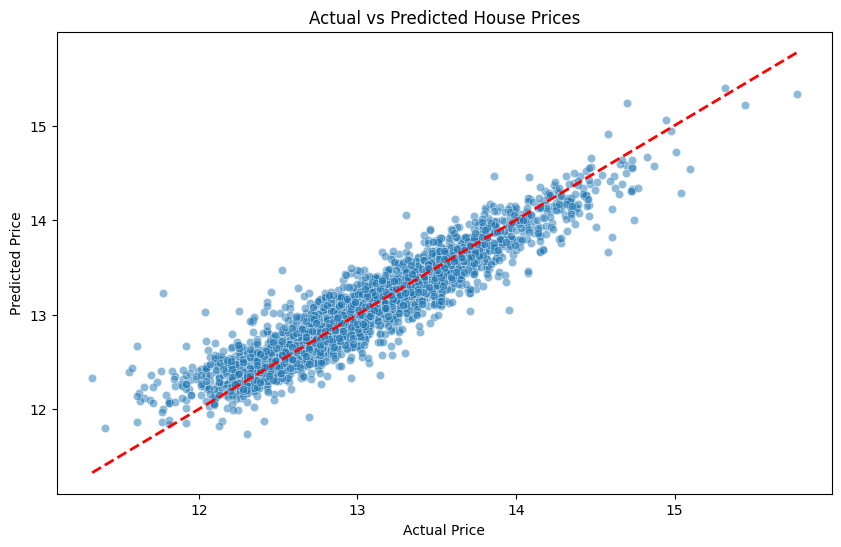

In [10]:
# Get the best model
best_model = grid_search.best_estimator_

# Predict on Test Set
y_pred = best_model.predict(X_test)

# Convert Log predictions back to Real Dollars ($) for readability (using expm1 to reverse log1p transformation)
y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_pred)

# Metrics
r2 = r2_score(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae = mean_absolute_error(y_test_original, y_pred_original)

print("--- Test Set Evaluation ---")
print(f"R2 Score: {r2:.3f}")
print(f"RMSE: ${rmse:,.0f}")
print(f"MAE: ${mae:,.0f}")
print("\n")

# Plot Predicted vs Actual
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted House Prices")
plt.show()

**RESULT**
- Best model performance with tuned hyper parameters is less than the model perfromance of the received model from pipeline 
- So, proceedng with the previous model

---